In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from skimage.measure import regionprops, block_reduce, regionprops_table
import tifffile
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
import sklearn.cluster as cluster
import seaborn as sns
import random

datapath = Path.cwd().parent / "data"

In [3]:
from src.visualization.plotting import plotset, plot_transition_heatmap
from src import utils

In [4]:
rawpath = datapath / "interim/confocal/histone_test.tif"
trackpath = datapath / "interim/confocal/histone_test_tracked.tif"

raw = tifffile.imread(rawpath)
tracked = tifffile.imread(trackpath)

In [5]:
nucleus_df = utils.get_nucleus_df(raw, tracked)

rad = 20
h = 2*rad + 1
nucleus_df = utils.get_normed_intensity_image(nucleus_df, raw, rad=rad)

129it [00:21,  6.09it/s]
100%|██████████| 46472/46472 [00:20<00:00, 2307.68it/s]
46472it [00:21, 2187.02it/s]


In [6]:
nucleus_df.head()

,track,x,y,t,rad,eccentricity,orientation,label_image,parent,img,img_rot,img_reduced
0,1,623.336585,862.902439,0,20.658998,0.394333,-1.362516,"[[False, False, False, False, False, False, Fa...",NaN,"[[0.0, 0.2, 0.2, 0.11428571428571428, 0.192857...","[[0.0, 0.0, 0.0, 0.0, 0.0038942881966798114, 0...","[[0.1392857142857143, 0.16428571428571428, 0.3..."
1,2,521.305099,872.394123,0,21.151589,0.566266,-1.547674,"[[False, False, False, False, False, False, Fa...",NaN,"[[0.04, 0.136, 0.024, 0.0, 0.112, 0.304, 0.184...","[[0.16925671555525065, 0.2637932288790363, 0.2...","[[0.096, 0.07800000000000001, 0.136, 0.118, 0...."
2,3,727.246619,904.117741,0,21.644347,0.515369,0.553031,"[[False, False, False, False, False, False, Fa...",NaN,"[[0.1388888888888889, 0.1597222222222222, 0.24...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[[0.09722222222222222, 0.14756944444444445, 0...."
3,4,2440.362031,2165.038263,0,21.839099,0.405457,-0.009642,"[[False, False, False, False, False, False, Fa...",NaN,"[[0.0, 0.0, 0.0, 0.0, 0.022388059701492536, 0....","[[0.0, 0.0, 0.0, 0.00362827898057352, 0.015286...","[[0.020522388059701493, 0.011194029850746268, ..."
4,5,1503.011290,932.149194,0,21.613020,0.528370,1.491108,"[[False, False, False, False, False, False, Fa...",NaN,"[[0.11023622047244094, 0.4094488188976378, 0.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0132882...","[[0.16141732283464566, 0.24803149606299213, 0...."


129it [00:03, 36.73it/s]


<Axes: >

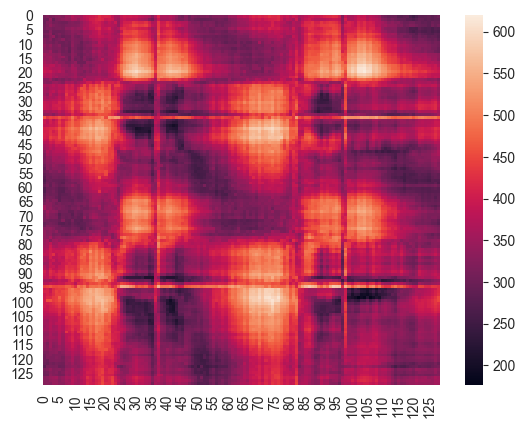

In [7]:
discrete_rotations = np.arange(0, 360, 45)
import skimage.transform as transform

# return minimum pairwise distances between two images, rotated by discrete_rotations
def get_min_pairwise_distance(img1, img2, discrete_rotations):
    min_dist = np.inf
    best_rot = 0
    for rot in discrete_rotations:
        img2_rot = transform.rotate(img2, rot)
        dist = np.sum((img1 - img2_rot)**2)
        if dist < min_dist:
            min_dist = dist
            best_rot = rot
    print(best_rot)
    return min_dist

def get_pairwise_by_orientation(img1, img2, orientation1, orientation2):
    img2_rot = transform.rotate(img2, np.rad2deg(orientation2 - orientation1))
    return np.sum(np.abs((img1 - img2_rot)))

k1, k2 = 5, 25
imgs_k = []
ori_k = []
for k in [k1, k2]:
    track = nucleus_df[nucleus_df["track"] == k]
    imgs = [img for img in track["img"]]
    ori = [ori for ori in track["orientation"]]
    imgs_k.append(imgs)
    ori_k.append(ori)

distance_matrix = np.zeros((len(imgs_k[0]), len(imgs_k[1])))

for i, (img_1, ori_1) in tqdm(enumerate(zip(imgs_k[0], ori_k[0]))):
    for j, (img_2, ori_2) in enumerate(zip(imgs_k[1], ori_k[1])):
        distance_matrix[i, j] = get_pairwise_by_orientation(img_1, img_2, ori_1, ori_2)

sns.heatmap((distance_matrix))


In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np

imgs_rotated = []
for imgs, oris in zip(imgs_k, ori_k):
    imgs_rotated.append([transform.rotate(img, np.rad2deg(-ori)) for img, ori in zip(imgs, oris)])
    
s1 = np.array([img.flatten() for img in imgs_rotated[0]])
s2 = np.array([img.flatten() for img in imgs_rotated[1]])[5:]

distance_matrix = np.zeros((len(s1), len(s2)))

for i, img1 in enumerate(s1):
    for j, img2 in enumerate(s2):
        distance_matrix[i, j] = np.sum((img1 - img2)**2)


sns.set_context("paper")
fig, ax = plt.subplots(1, 1, figsize=(4, 3.9))

sns.heatmap(distance_matrix.T, cbar_kws={"label": "L2 distance"}, ax=ax, cmap="viridis_r")

d, paths = dtw.warping_paths(s1, s2)
best_path = dtw.best_path(paths)

x = np.array([i for i, j in best_path])
y = np.array([j for i, j in best_path])

plt.plot(x, y, color="black", linewidth=1.5)

plt.xlabel("Seq 1 time (min)")
plt.ylabel("Seq 2 time (min)")
plt.title("DTW alignment")

ax.set_xticks(np.arange(0, len(s1), 20), labels=(np.arange(0, len(s1), 20, dtype=int)//4))
ax.set_yticks(np.arange(0, len(s2), 20), labels=(np.arange(0, len(s2), 20, dtype=int)//4))

# plt.show()



plt.savefig(Path(r"D:\OneDrive - Princeton University\GeneralExam\figures") / "dtw_path.png", dpi=300)
# print(best_path)
# 
# plt.figure()
# sns.heatmap(distance_matrix)
# plt.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1])
# plt.show()

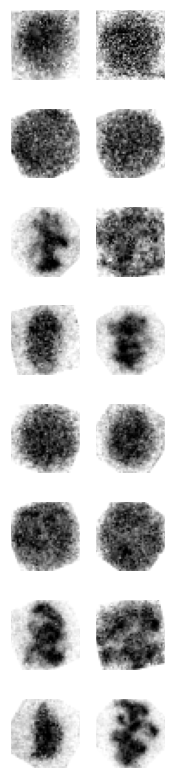

In [9]:
fig, axes = plt.subplots(8, 2, figsize=(2, 10))
t_points = range(0, 120, 15)
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        img = imgs_rotated[j][best_path[t_points[i]][j]]
        ax.imshow(img, cmap="gray_r")
        ax.set_xticks([])
        ax.set_yticks([])

# plt.savefig(Path(r"D:\OneDrive - Princeton University\GeneralExam\figures") / "sample_alignment.png", dpi=1200)
plt.show()

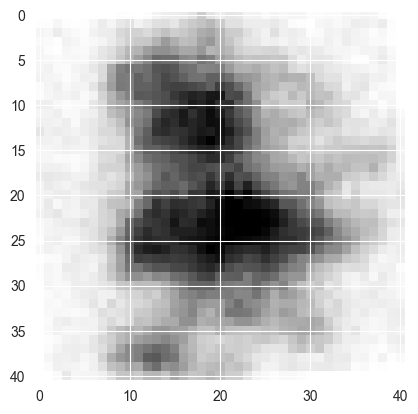

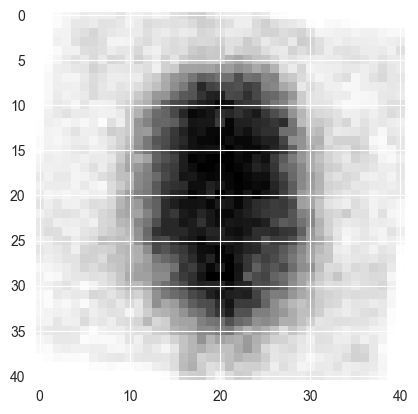

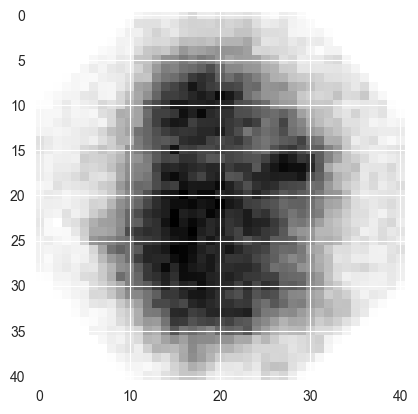

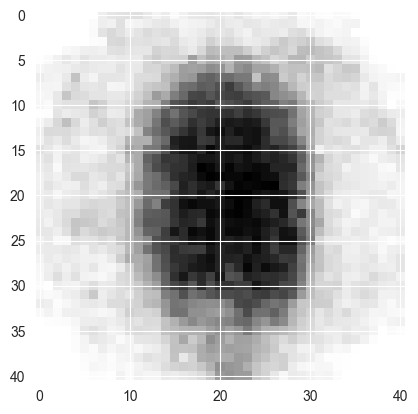

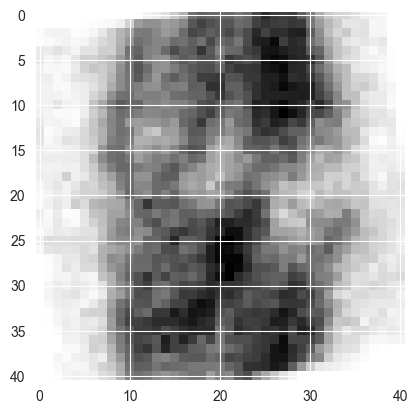

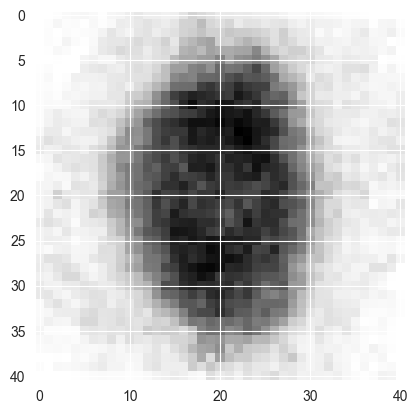

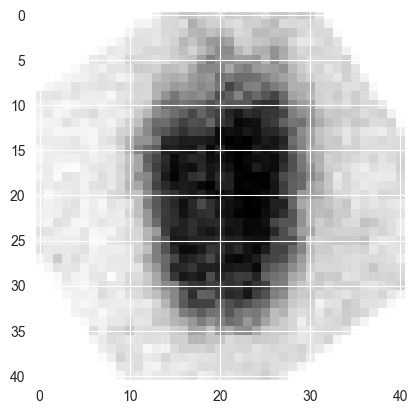

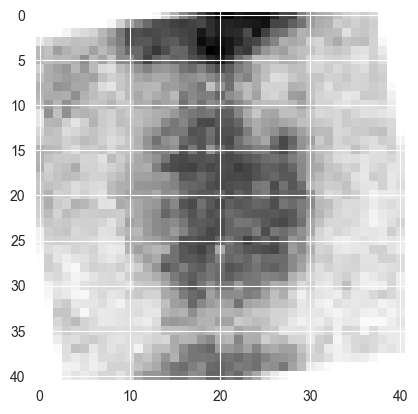

In [157]:

df = nucleus_df[nucleus_df["t"].between(80, 120)]

valid_tracks = df.groupby("track").filter(lambda x: len(x) >= 40)["track"].unique()
chosen_tracks = np.random.choice(valid_tracks, 16, replace=False)

def get_track_imgs(track):
    track_df = df[df["track"] == track]
    imgs = [img for img in track_df["img_rot"]]
    imgs_flat = np.array([img.flatten() for img in imgs])
    return imgs, imgs_flat

def merge_tracks(imgs1, imgs2, best_path):
    merged_imgs = []
    for i, j in best_path:
        merged_imgs.append(np.mean([imgs1[i], imgs2[j]], axis=0))
    return merged_imgs

def dtw_dis(track1, track2):
    imgs1, imgs_flat1 = get_track_imgs(track1)
    imgs2, imgs_flat2 = get_track_imgs(track2)
    
    d, paths = dtw.warping_paths(imgs_flat1, imgs_flat2)
    
    return d

def dtw_merge(track1, track2):
    imgs1, imgs_flat1 = get_track_imgs(track1)
    imgs2, imgs_flat2 = get_track_imgs(track2)
    
    d, paths = dtw.warping_paths(imgs_flat1, imgs_flat2)
    best_path = dtw.best_path(paths)
    
    merged_imgs = merge_tracks(imgs1, imgs2, best_path)
    merged_flats = np.array([img.flatten() for img in merged_imgs])
    return merged_imgs, merged_flats, best_path


pairwise_distances = np.zeros((len(chosen_tracks), len(chosen_tracks)))

for i, track1 in enumerate(chosen_tracks):
    for j, track2 in enumerate(chosen_tracks):
        if i != j:
            d = dtw_dis(track1, track2)
            pairwise_distances[i, j] = d

        
for track1, track2 in zip(chosen_tracks[0::2], chosen_tracks[1::2]):
    merged, merged_flats, best_path = dtw_merge(track1, track2)
    plt.imshow(merged[15], cmap="gray_r")
    plt.show()



# merged, merged_flats, best_path = dtw_merge(chosen_tracks[0], chosen_tracks[1])

# plt.imshow(merged[10], cmap="gray_r")
# plt.show()
    

C:\Users\Harrison\AppData\Local\Temp\ipykernel_12780\1466970164.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["density"] = densities


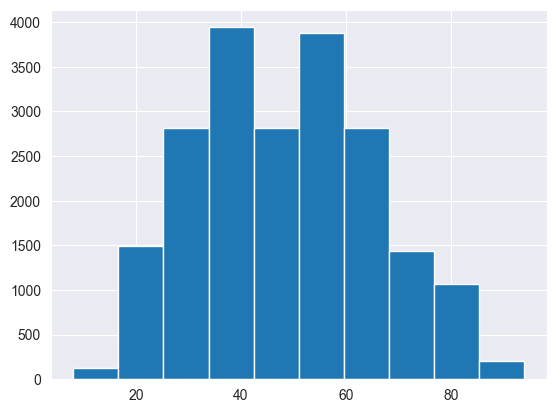

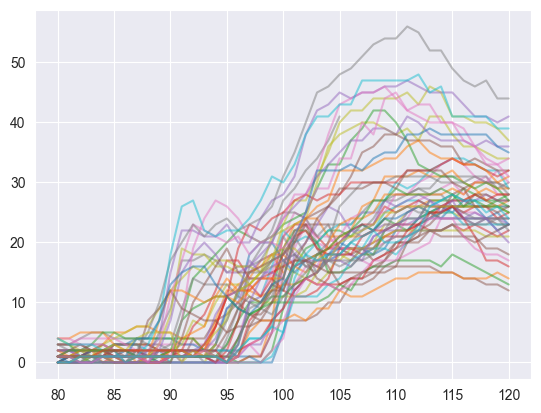

In [53]:
from sklearn.metrics import pairwise_distances

count_dis = 300

distances_matrices = {}
densities = []

for t in range(80, 121):
    frame = nucleus_df[nucleus_df["t"] == t]
    distance_matrix = pairwise_distances(np.hstack([frame["x"].values.reshape(-1, 1), frame["y"].values.reshape(-1, 1)]))
    distances_matrices[t] = distance_matrix
    
    density = np.sum(distance_matrix < count_dis, axis=1)
    densities.extend(density)
    
temp_df = nucleus_df[nucleus_df["t"].between(80, 120)]
temp_df["density"] = densities
    
temp_df["density"].hist()
plt.show()

for k in range( 100):
    track = temp_df[temp_df["track"] == k]
    plt.plot(track["t"], track["density"] - track["density"].min(), alpha=0.5)
    
plt.show()

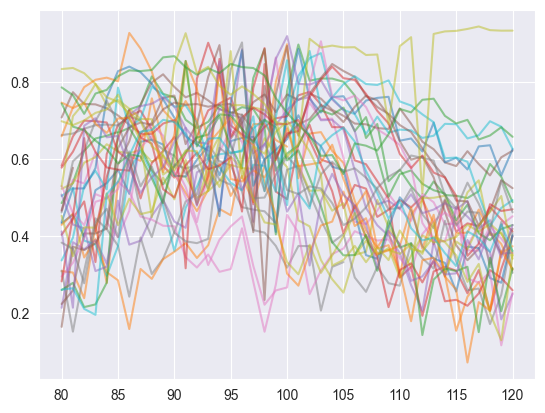

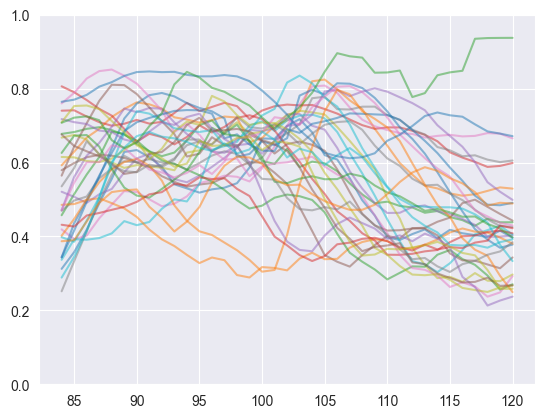

In [45]:
start, stop = 80, 120
df = nucleus_df[nucleus_df["t"].between(start, stop)]

plt.figure()

for k in range(50):
    track = df[df["track"] == k]
    plt.plot(track["t"], track["eccentricity"], alpha=0.5)
    
plt.show()

plt.figure()

for k in range(50):
    track = df[df["track"] == k]
    if len(track) >= stop - start:
        rad_normed = track["eccentricity"].rolling(5).mean()
        plt.plot(track["t"], rad_normed, alpha=0.5)

plt.ylim(0, 1)
plt.show()

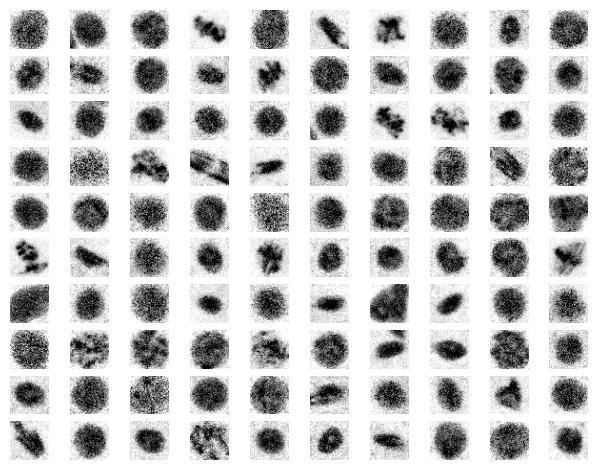

In [8]:
plotset(list(nucleus_df.sample(100)["img"]), 10, reshape=(h,h))

## autoencoder approach

In [138]:
# Shape of input and latent variable

n_input = h*h

# Encoder structure
n_encoder1 = 500
n_encoder2 = 300

n_latent = 16

# Decoder structure
n_decoder2 = 300
n_decoder1 = 500

In [139]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                   activation = 'relu',
                   solver = 'adam',
                   learning_rate_init = 0.0001,
                   max_iter = 5,
                   tol = 0.0000001,
                   verbose = True)

In [140]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(nucleus_df["img"], test_size=0.2)
train_arr = np.array([t for t in train])
test_arr = np.array([t for t in test])


reg.fit(train_arr, train_arr)

Iteration 1, loss = 0.03468268
Iteration 2, loss = 0.01509771
Iteration 3, loss = 0.01354487
Iteration 4, loss = 0.01307650
Iteration 5, loss = 0.01276361


C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(500, 300, 16, 300, 500),
             learning_rate_init=0.0001, max_iter=5, tol=1e-07, verbose=True)

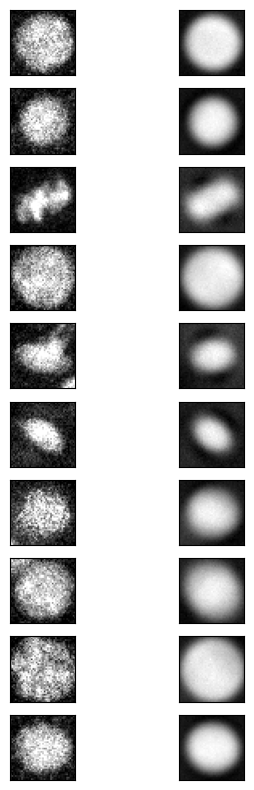

In [148]:
n = 10
idx = np.random.randint(test_arr.shape[0], size=n)
x_reconst = [reg.predict(test_arr[id].reshape(-1,h**2)) for id in idx]

plt.figure(figsize = (4, 10))
for j in range(n):
    plt.subplot(n,2,2*j+1)
    plt.imshow(test_arr[idx[j]].reshape(h, h), 'gray')
    # plt.title('Imput Image', fontsize = 15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(n,2,2*j+2)
    plt.imshow(x_reconst[j].reshape(h, h), 'gray')
    # plt.title('Reconstructed Image', fontsize = 15)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [163]:
def encoder(data):
    data = np.asmatrix(data)

    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))

    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))

    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))

    return np.asarray(latent)
img_arr = np.array([img for img in nucleus_df["img"]])
latent = encoder(img_arr)
t_arr = np.expand_dims(np.array(nucleus_df["t"]), 1)
latent = np.hstack([latent, t_arr/np.max(t_arr)])

In [164]:
latent_class = umap.UMAP()
latent_embeddings = latent_class.fit_transform(latent)
nucleus_df["lat_embedding_0"] = latent_embeddings[:, 0]
nucleus_df["lat_embedding_1"] = latent_embeddings[:, 1]

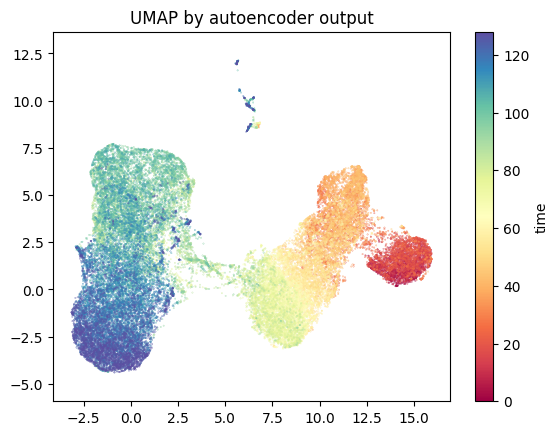

In [171]:
plt.scatter(latent_embeddings[:, 0], latent_embeddings[:, 1], c=nucleus_df["t"], cmap='Spectral', s=.05)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(label="time")
plt.title('UMAP by autoencoder output')

plt.savefig(str(Path.cwd().parent / "results/plots/unet_umap_ae_withtime.png"), dpi=1200)

plt.show()

C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


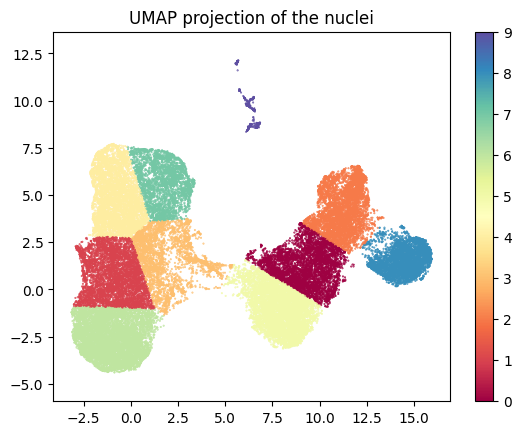

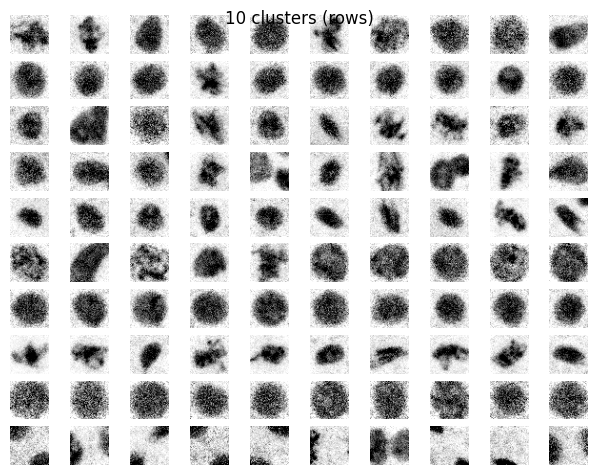

[6, 1, 4, 3, 7, 5, 0, 2, 8, 9]
4052 0.8864515571641624
3911 1.0000000000000002


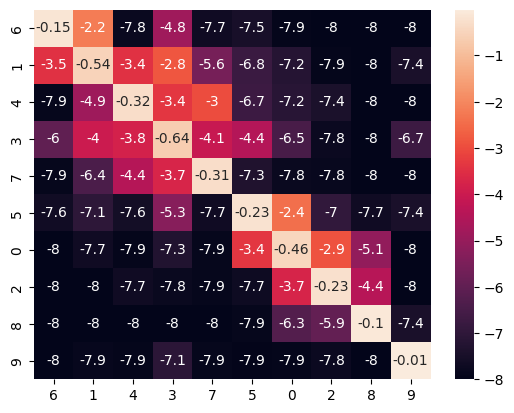

In [173]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(latent_embeddings)

nucleus_df["kmeans_cluster"] = kmeans_labels

plt.scatter(latent_embeddings[:, 0], latent_embeddings[:, 1], c=kmeans_labels, cmap='Spectral', s=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the nuclei')
plt.show()

fig, ax_array = plt.subplots(10, 10)
for i, ax_row in enumerate(ax_array):
    cluster_imgs = list(nucleus_df[nucleus_df["kmeans_cluster"] == i].sample(10)["img"])
    for j, ax in enumerate(ax_row):
        img = cluster_imgs[j].reshape(h, h)
        ax.imshow(img, cmap="gray_r")

plt.setp(ax_array.flatten(), xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)
plt.suptitle("10 clusters (rows)")
plt.show()

plot_transition_heatmap()

## cellpose-based classification

In [111]:
from cellpose import models
import torch

cyto = models.CellposeModel(model_type="cyto")

def ctrl_pass(img):
    return [np.mean(img), np.random.random(1), np.random.random(1)]

def cellpose_pass(img, w=h):
    img = img.reshape((w,w))
    zeros = np.zeros_like(img)
    img_arr = np.array([[img, zeros]])
    out = cyto.net.downsample.down[0](torch.tensor(img_arr, dtype=torch.float32, device="cpu")).detach().numpy()
    return out.max(axis=(2, 3))[0]

nucleus_df["cellpose_vec"] = [cellpose_pass(img) for img in tqdm(nucleus_df["img"])]

100%|███████████████████████████████████████████████████████████████████████████| 46472/46472 [01:20<00:00, 576.71it/s]


In [112]:
cellpose_vectors = np.array(nucleus_df["cellpose_vec"])
cellpose_vectors = np.array([a for a in cellpose_vectors])
cellpose_vectors.shape

(46472, 32)

In [113]:
unet_class = umap.UMAP()
unet_embeddings = unet_class.fit_transform(cellpose_vectors)

In [114]:
nucleus_df["cellpose_embedding_0"] = unet_embeddings[:, 0]
nucleus_df["cellpose_embedding_1"] = unet_embeddings[:, 1]

In [115]:
sub_n = 500
sub_points = nucleus_df[nucleus_df["parent"] > 0].sample(sub_n)
xs, ys, dxs, dys = [], [], [], []

for pt in sub_points.index:
    if nucleus_df["parent"][pt] is not None:
        parent = int(nucleus_df["parent"][pt])
        x = unet_embeddings[pt, 0]
        y = unet_embeddings[pt, 1]
        px = unet_embeddings[parent, 0]
        py = unet_embeddings[parent, 1]
        xs.append(px)
        ys.append(py)
        dxs.append(x - px)
        dys.append(y - py)

In [116]:
n = 3
tracks = nucleus_df["track"].sample(n)
xs, ys, colors, ts = [], [], [], []
for track in tracks:
    xs.append(nucleus_df[nucleus_df["track"]==track]["cellpose_embedding_0"])
    ys.append(nucleus_df[nucleus_df["track"]==track]["cellpose_embedding_1"])
    ts.append(nucleus_df[nucleus_df["track"]==track]["t"])
    colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))

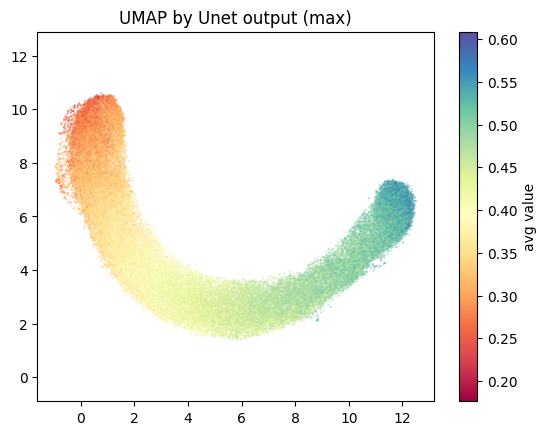

In [119]:
plt.scatter(unet_embeddings[:, 0], unet_embeddings[:, 1], c=[np.mean(img) for img in nucleus_df["img"]], cmap='Spectral', s=.05)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(label="avg value")
plt.title('UMAP by Unet output (max)')

# plt.quiver(xs, ys, dxs, dys, angles="xy", scale=1.0, scale_units="xy")

# for x, y, c in zip(xs, ys, colors):
#     plt.plot(x, y, c=c)

plt.show()

C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


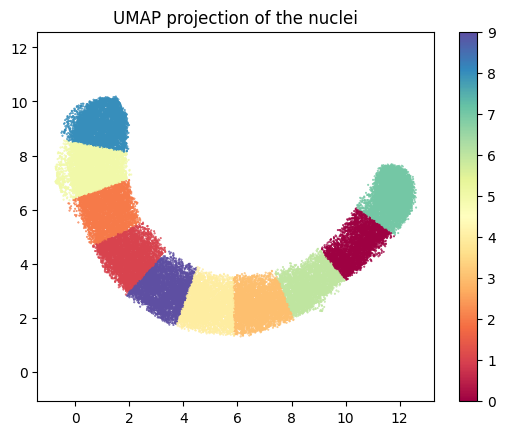

In [98]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(unet_embeddings)

nucleus_df["kmeans_cluster"] = kmeans_labels

plt.scatter(unet_embeddings[:, 0], unet_embeddings[:, 1], c=kmeans_labels, cmap='Spectral', s=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the nuclei');

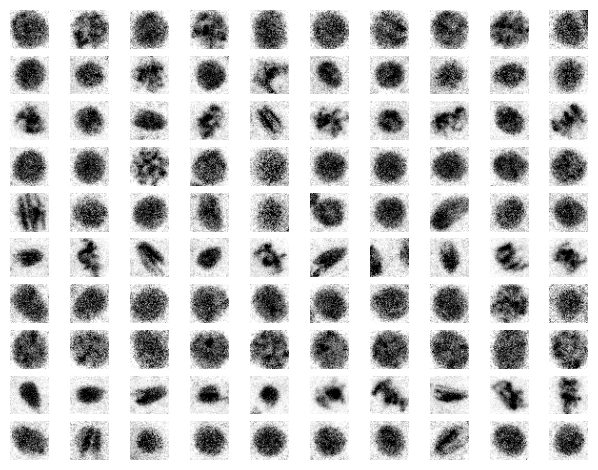

In [99]:
fig, ax_array = plt.subplots(10, 10)
for i, ax_row in enumerate(ax_array):
    cluster_imgs = list(nucleus_df[nucleus_df["kmeans_cluster"]==i].sample(10)["img"])
    for j, ax in enumerate(ax_row):
        img = cluster_imgs[j].reshape(h,h)
        ax.imshow(img, cmap="gray_r")

plt.setp(ax_array.flatten(), xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)
plt.show()

[6, 0, 7, 8, 5, 2, 1, 4, 3, 9]
4051 1.0115549560803123
4943 1.0


<Axes: >

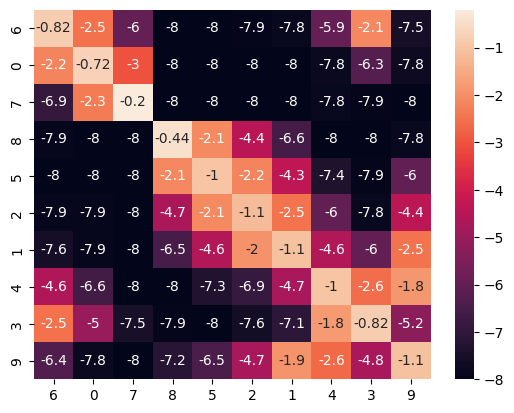

## Stat-based clustering

In [9]:
n = nucleus_df.shape[0]
stats = ["eccentricity", "inertia_tensor", "moments_hu"]
stat_names = regionprops_table(tracked[0], raw[0], stats).keys()
n_stats = len(stat_names)
stat_vectors = np.zeros((0, n_stats))

for t, frame in tqdm(enumerate(tracked)):
    table = regionprops_table(frame, raw[t], properties=stats)
    arr = np.array([val for key, val in table.items()]).T
    stat_vectors = np.vstack((stat_vectors, arr))

129it [00:16,  7.96it/s]


In [10]:
los, his = np.quantile(stat_vectors, 0.05, axis=0), np.quantile(stat_vectors, 0.95, axis=0)
stat_vectors = (stat_vectors - los)/(his-los)

In [11]:
stat_vectors_clipped = np.clip(stat_vectors, 0, 1)
stat_vectors_clipped

array([[0.26513634, 0.55348742, 0.58518371, ..., 0.06487589, 0.165853  ,
        0.52557274],
       [0.57176584, 0.60925735, 0.53035424, ..., 0.0650252 , 0.16917214,
        0.52596272],
       [0.48099531, 0.44465802, 0.21076124, ..., 0.06836741, 0.18220971,
        0.53158032],
       ...,
       [0.69982636, 0.57472229, 0.17229359, ..., 0.        , 0.        ,
        0.8516982 ],
       [0.68943792, 0.        , 0.60563044, ..., 0.30743901, 0.35462131,
        0.        ],
       [0.39467428, 0.22852616, 0.70113091, ..., 0.13068006, 0.22967134,
        0.45979443]])

In [12]:
print(stat_names)

dict_keys(['eccentricity', 'inertia_tensor-0-0', 'inertia_tensor-0-1', 'inertia_tensor-1-0', 'inertia_tensor-1-1', 'moments_hu-0', 'moments_hu-1', 'moments_hu-2', 'moments_hu-3', 'moments_hu-4', 'moments_hu-5', 'moments_hu-6'])


In [14]:
stat_class = umap.UMAP()
stat_embeddings = stat_class.fit_transform(stat_vectors_clipped)

In [15]:
sub_n = 500
sub_points = nucleus_df[nucleus_df["parent"] > 0].sample(sub_n)
xs, ys, dxs, dys = [], [], [], []

for pt in sub_points.index:
    if nucleus_df["parent"][pt] is not None:
        parent = int(nucleus_df["parent"][pt])
        x = stat_embeddings[pt, 0]
        y = stat_embeddings[pt, 1]
        px = stat_embeddings[parent, 0]
        py = stat_embeddings[parent, 1]
        xs.append(px)
        ys.append(py)
        dxs.append(x - px)
        dys.append(y - py)


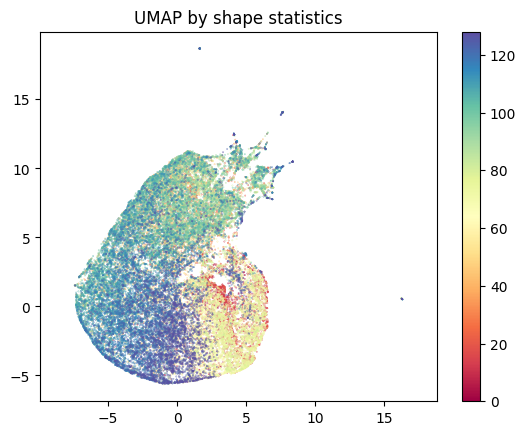

In [88]:
plt.scatter(stat_embeddings[:, 0], stat_embeddings[:, 1], c=nucleus_df["t"], cmap='Spectral', s=0.05)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP by shape statistics');

# plt.quiver(xs, ys, dxs, dys, angles="xy", scale=1.0, scale_units="xy")
plt.show()

C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


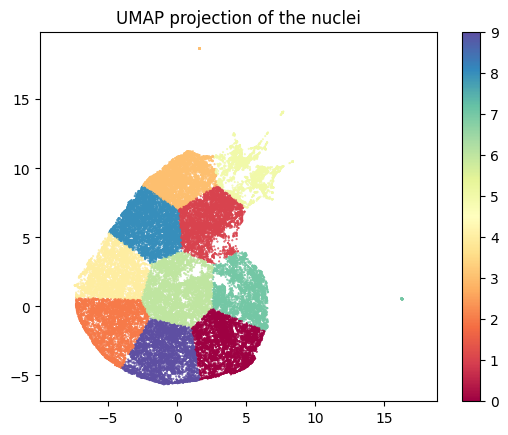

In [17]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(stat_embeddings)

nucleus_df["kmeans_cluster"] = kmeans_labels

plt.scatter(stat_embeddings[:, 0], stat_embeddings[:, 1], c=kmeans_labels, cmap='Spectral', s=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the nuclei');

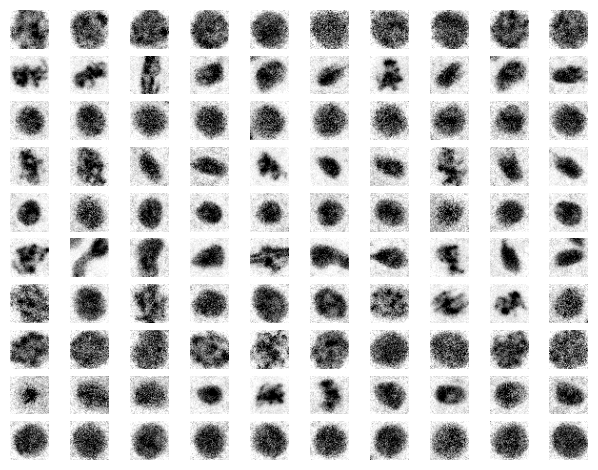

In [18]:
fig, ax_array = plt.subplots(10, 10)
for i, ax_row in enumerate(ax_array):
    cluster_imgs = list(nucleus_df[nucleus_df["kmeans_cluster"]==i].sample(10)["img"])
    for j, ax in enumerate(ax_row):
        img = cluster_imgs[j].reshape(h,h)
        ax.imshow(img, cmap="gray_r")

plt.setp(ax_array.flatten(), xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)
plt.show()

In [19]:
nucleus_df["parent"]

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
46467    45883.0
46468    45884.0
46469        NaN
46470        NaN
46471        NaN
Name: parent, Length: 46472, dtype: float64

In [20]:
from scipy.cluster.hierarchy import dendrogram

def order_clustering(children):
    n = len(children) + 1
    def recursive_split(k):
        if k < n:
            return [k]
        left, right = children[k - n]
        return recursive_split(left) + recursive_split(right)
    return recursive_split(len(children) + n - 1)

[7, 0, 9, 6, 5, 1, 8, 4, 2, 3]
4408 1.0568612246775817
5268 1.0


<Axes: >

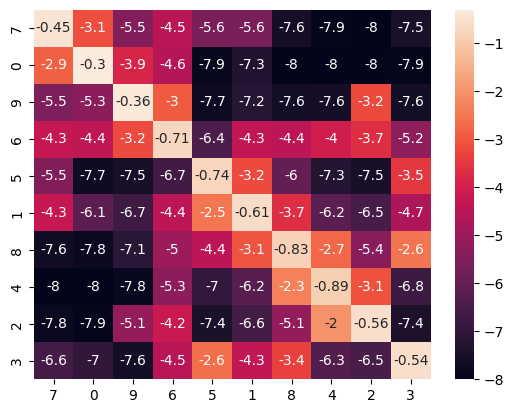

In [21]:
from sklearn.cluster import AgglomerativeClustering

nucleus_df["kmc"] = nucleus_df["kmeans_cluster"].astype("int").astype("category")
parent_cluster = [nucleus_df["kmc"][p] if not pd.isna(p) else None for p in nucleus_df["parent"]]
nucleus_df["pkmc"] = parent_cluster
transitions = np.array(pd.crosstab(nucleus_df["kmc"], nucleus_df["pkmc"]))
distance = 1/(np.array(transitions + 1))
transition_probs = transitions/np.sum(transitions, axis=0)
clustering = AgglomerativeClustering(metric="precomputed", linkage="single")
clustering.fit(distance)
order = order_clustering(clustering.children_)
order = order[::-1]
print(order)
transitions_reorder = np.zeros_like(transition_probs)
transitions_reorder = transition_probs[order, :]
transitions_reorder = transitions_reorder[:, order]

print(np.sum(transitions[2, :]), np.sum(transitions_reorder[3, :]))
print(np.sum(transitions[:, 8]), np.sum(transitions_reorder[:, 6]))
sns.heatmap(np.log2(transitions_reorder+1/2**8), annot=True, xticklabels=order, yticklabels=order)

## UMAP directly against image

In [40]:
img_class = umap.UMAP(min_dist=0.0)
embeddings = img_class.fit_transform(imgs)

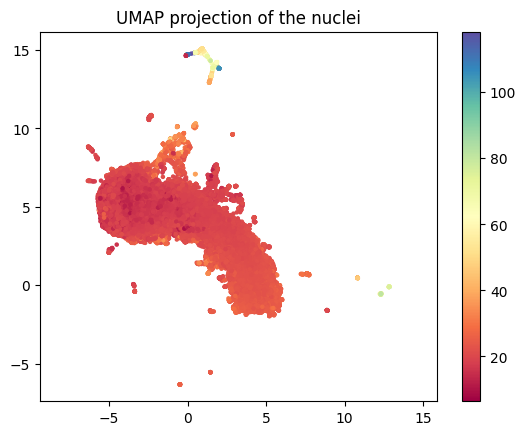

In [41]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=subset["rad"], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the nuclei');

C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'UMAP projection of the nuclei')

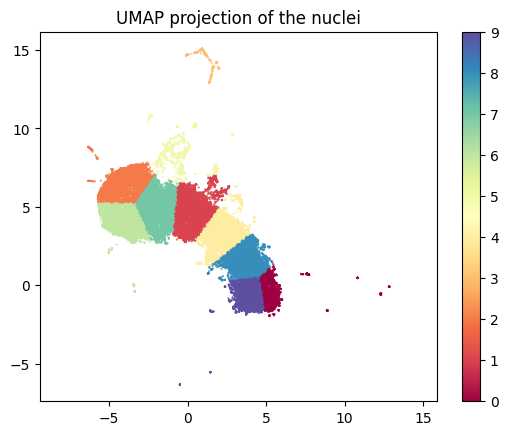

In [164]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(embeddings)

nucleus_df["kmeans_cluster"] = kmeans_labels

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=kmeans_labels, cmap='Spectral', s=0.2)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the nuclei')

In [43]:
subset["umap_0"] = embeddings[:, 0]
subset["umap_1"] = embeddings[:, 1]
subset["cluster"] = labels

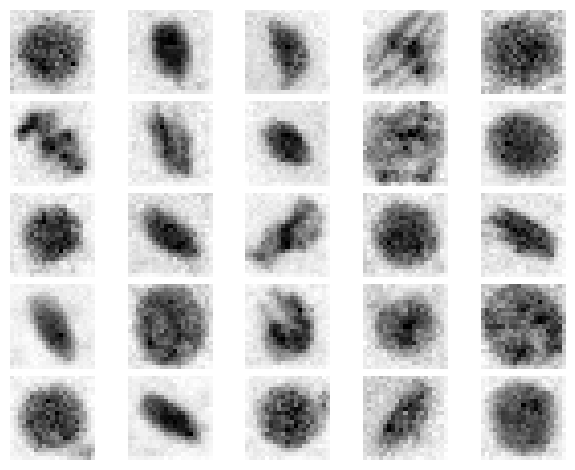

In [44]:
plotset(list(subset[subset["cluster"] == 1].sample(25)["img"]), 5, (rad+1, rad+1))